# imports

In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import transforms
from torchvision.transforms import v2
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision
from torch.utils.data import DataLoader, Dataset, Subset
from torch import flatten, optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score,f1_score
from PIL import Image
from tqdm import tqdm

import time


In [2]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()


In [3]:
BATCH_SIZE = 7
SHUFFLE = True
LEARNING_RATE = 0.001
EPOCHS = 5

CUDA = True
if CUDA and torch.cuda.is_available():
    device = "cuda"
else: device = "cpu"
print("device is:",device)

device is: cuda


# Functions

In [4]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

import time
from tqdm import tqdm  # Import tqdm for the progress bar

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best_val_loss = 1000
    best_model = model
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            # labels = labels.unsqueeze(-1) # -1 stands for last here equivalent to 1
            loss = criterion(outputs, labels)
            loss = loss.to(device)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * inputs.size(0)
        
        train_loss /= len(train_loader.dataset)
        writer.add_scalar("loss/train", train_loss, epoch)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
        
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
    
    val_loss /= len(val_loader.dataset)
    
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model
    return best_model

def labelcounter(dataloader):
    pos,neg = 0,0
    for pic, label in dataloader:
        label_values = label.tolist()
        for label_value in label_values:
            if label_value == 0:
                neg += 1
            else:
                pos += 1
    return pos,neg
def test_model(model, test_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        test_loss = 0.0
        correct = 0
        total = 0
        all_predictions = []
        all_targets = []

        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(labels.cpu().numpy())

        test_loss /= len(test_loader.dataset)
        accuracy = 100 * correct / total
        
        # Calculate confusion matrix
        conf_matrix = confusion_matrix(all_targets, all_predictions)
        # Calculate additional metrics
        precision = precision_score(all_targets, all_predictions, average='weighted')
        recall = recall_score(all_targets, all_predictions, average='weighted')
        f1 = f1_score(all_targets, all_predictions, average='weighted')

    return test_loss, accuracy, precision, recall, f1, conf_matrix

# Dataset

In [5]:
TRAIN_DATA_DIR = r"C:\Users\ludvi\Documents\Code\tjena\chest_xray\train"
VAL_DATA_DIR = r"C:\Users\ludvi\Documents\Code\tjena\chest_xray\val"
TEST_DATA_DIR = r"C:\Users\ludvi\Documents\Code\tjena\chest_xray\test"

In [6]:
# transform = v2.Compose([
#         v2.Resize(size=(224,224)),
#         v2.RandomHorizontalFlip(p=0.5),
#         v2.ToTensor(),
#         v2.ToDtype(torch.float32, scale=True),  # Normalize expects float input
#         v2.Normalize(mean=[0.485, 0.456, 0.406],
#                             std=[0.229, 0.224, 0.225])
#     ])
transform = transforms.Compose([
        transforms.Resize(size=(224,224)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
    ])
# Load dataset
train_set = datasets.ImageFolder(root=TRAIN_DATA_DIR, transform=transform)
val_set = datasets.ImageFolder(root=VAL_DATA_DIR,transform=transform)
test_set = datasets.ImageFolder(root=TEST_DATA_DIR,transform=transform)

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False)

# transToPIL = v2.ToPILImage()
# img = transToPIL(train_set[0][0])
# img.show()

print("train set size:",len(train_set))
print("val set size:",len(val_set))
print("test set size:",len(test_set))



train set size: 5216
val set size: 16
test set size: 624


In [7]:
train_pos,train_neg = labelcounter(train_loader)
val_pos,val_neg = labelcounter(val_loader)
test_pos,test_neg = labelcounter(test_loader)

species = ('train', 'val', 'test')
balance = {
    'positive': np.array([train_pos, val_pos, test_pos]),
    'negative': np.array([train_neg, val_neg, test_neg]),
}
width = 0.7  # the width of the bars: can also be len(x) sequence


fig, ax = plt.subplots()
bottom = np.zeros(3)

for positive, negative in balance.items():
    p = ax.bar(species, negative, width, label=positive, bottom=bottom)
    bottom += negative

    ax.bar_label(p, label_type='center')

ax.set_title('Dataset balance')
ax.legend()

plt.show()

KeyboardInterrupt: 

# Models

In [8]:
class custom_resnet(nn.Module):
    def init(self):
        super().init()
        self.resnet = torchvision.models.resnet101(pretrained=True)
        modules = list(self.resnet.children())[:-2]
        self.resnet = nn.Sequential(*modules)
        self.dem_red1 = nn.Conv2d(2048, 1024, kernel_size=1, padding=0)
        self.dem_red2 = nn.Conv2d(1024, 512, kernel_size=1, padding=0)
        self.fc1 = nn.Linear(5127*7,1000)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(1000,1)
        self.myparameters = nn.ParamersList(self.resnet, self.dem_red1,self.dem_red2,self.fc1,self.fc2)

    def forward(self,x):
        x = self.resnet(x)
        x = self.act(x)
        x = self.dem_red1(x)
        x = self.act(x)
        x = self.dem_red2(x)
        x = self.act(x)
        x = torch.flatten(x,start_dim=1)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

In [9]:
class wtf(nn.Module):
    def __init__(self):
        super().__init__()

        self.RELU = nn.ReLU()
        self.Tan = nn.Tanh()

        self.densenet = torchvision.models.densenet.DenseNet()
        
        # input: 32x32x1
        self.c1 = nn.Conv2d(1, 3, kernel_size=3, padding=1) # output: 32x32x3 SAME
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x3 
        self.c2 = nn.Conv2d(3, 6, kernel_size=3, padding=1) # output: 16x16x6 SAME
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 8x8x6 
        self.c3 = nn.Conv2d(6, 12, kernel_size=3, padding=1) # output: 8x8x12 SAME
        
        self.fc1 = nn.Linear(in_features=8*8*12, out_features=60) 

        self.logSoftmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        #Conv Layer 1
        x = self.c1(x)
        x = self.act(x)
        x = self.pool1(x)
        #Conv Layer 2        
        x = self.c2(x)
        x = self.act(x)
        x = self.pool2(x)
        #Conv Layer 3
        x = self.c3(x)
        x = self.act(x)
        #Flattening
        x = torch.flatten(x, 1)
        #FC Layer 1
        x = self.fc1(x)
        x = self.act(x)
        #FC Layer 2
        x = self.fc2(x)    
        #Softmax
        out = self.logSoftmax(x)

        return out

In [14]:
class TransferLearning(nn.Module):
    def __init__(self, my_pretrained_model):
        super(TransferLearning, self).__init__()
        self.pretrained = my_pretrained_model
        self.my_new_layers = nn.Sequential(nn.Linear(1000, 100),
                                            nn.ReLU(),
                                            nn.Linear(100, 0)) # Binary classification?
    
    def forward(self, x):
        x = self.pretrained(x)
        x = self.my_new_layers(x)
        return x

In [13]:
densenet = TransferLearning(torchvision.models.densenet.densenet121()).to(device)
# print(densenet)
optimizer = torch.optim.Adam(params=densenet.parameters(),lr=0.0001)
# criterion = torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean').to(device)
criterion = torch.nn.BCELoss().to(device)


trained_model1 = train_model(densenet,criterion,optimizer,train_loader,val_loader,num_epochs=EPOCHS)
# Test the model
test_loss, accuracy, precision, recall, f1, conf_matrix = test_model(trained_model1, test_loader, criterion)

print("Accuracy:",accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:",f1)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=['Negative', 'Positive'], normalize=True)
plt.show()
writer.close()

Epoch 1/5:   0%|          | 0/746 [00:00<?, ?it/s]


ValueError: Using a target size (torch.Size([7])) that is different to the input size (torch.Size([7, 2])) is deprecated. Please ensure they have the same size.

Accuracy: 81.25
Precision: 0.8509090087573731
Recall: 0.8125
F1-Score: 0.7945215526079207
Test Loss: 0.0937, Test Accuracy: 81.25%
Confusion matrix, without normalization


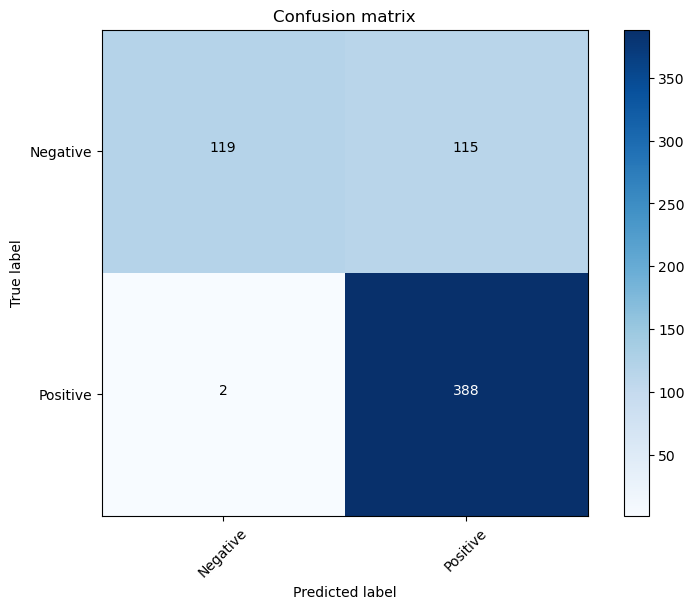

In [17]:
# resnet = torchvision.models.resnet101(pretrained=True).to(device)

# optimizer = torch.optim.Adam(params=densenet.parameters(),lr=0.0001)
# # criterion = torch.nn.BCELoss(weight=None, size_average=None, reduce=None, reduction='mean').to(device)
# criterion = torch.nn.CrossEntropyLoss().to(device)


# trained_model1 = train_model(densenet,criterion,optimizer,train_loader,val_loader,num_epochs=EPOCHS)
# # Test the model
test_loss, accuracy, precision, recall, f1, conf_matrix = test_model(trained_model1, test_loader,criterion)

print("Accuracy:",accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:",f1)

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
plt.figure(figsize=(8, 6))
plot_confusion_matrix(conf_matrix, classes=['Negative', 'Positive'], normalize=False)
plt.show()
writer.close()

Run 1: Resnet med aug

![alt text](image.png)